<a href="https://colab.research.google.com/github/YasinnSoylu/trading-boat-lstm-/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Kütüphaneler yüklenir
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
# Verileri yfinance'den almak
data = yf.download('TSLA', start='2023-05-15', end='2023-06-30',interval="15m")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-05-15 09:30:00,167.654999,169.699997,166.729996,169.509903,169.509903,11016343
2023-05-15 09:45:00,169.500000,169.690002,165.179993,165.320007,165.320007,9380600
2023-05-15 10:00:00,165.289993,166.440002,165.149994,165.929993,165.929993,6599472
2023-05-15 10:15:00,165.919998,166.660004,165.509995,166.257797,166.257797,5023895
2023-05-15 10:30:00,166.244995,166.889999,165.940002,166.369995,166.369995,3866755
...,...,...,...,...,...,...
2023-06-29 14:45:00,255.629898,256.989990,255.580002,256.820007,256.820007,3603240
2023-06-29 15:00:00,256.820007,257.309387,256.529999,256.757202,256.757202,3323411
2023-06-29 15:15:00,256.779999,257.049988,255.850006,256.320007,256.320007,3172249


In [21]:
# Verileri hazırlamak
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Verileri eğitim ve test setlerine bölmek
train_data = scaled_data[:int(len(scaled_data)*0.6)]
test_data = scaled_data[int(len(scaled_data)*0.6):]


In [22]:
# LSTM modeli oluşturulur
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam')

# Modeli eğitmek
history=model.fit(train_data[:-1].reshape(-1, 1, 1), train_data[1:].reshape(-1, 1, 1), epochs=100, batch_size=1)

Epoch 1/100
498/498 [==============================] - 6s 5ms/step - loss: 0.0169
Epoch 2/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0022
Epoch 3/100
498/498 [==============================] - 2s 3ms/step - loss: 0.0019
Epoch 4/100
498/498 [==============================] - 2s 3ms/step - loss: 0.0015
Epoch 5/100
498/498 [==============================] - 2s 3ms/step - loss: 0.0015
Epoch 6/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 7/100
498/498 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 8/100
498/498 [==============================] - 2s 5ms/step - loss: 8.9039e-04
Epoch 9/100
498/498 [==============================] - 2s 4ms/step - loss: 9.3805e-04
Epoch 10/100
498/498 [==============================] - 2s 3ms/step - loss: 8.6178e-04
Epoch 11/100
498/498 [==============================] - 2s 3ms/step - loss: 9.5214e-04
Epoch 12/100
498/498 [==============================] - 2s 3ms/step - loss: 9.08

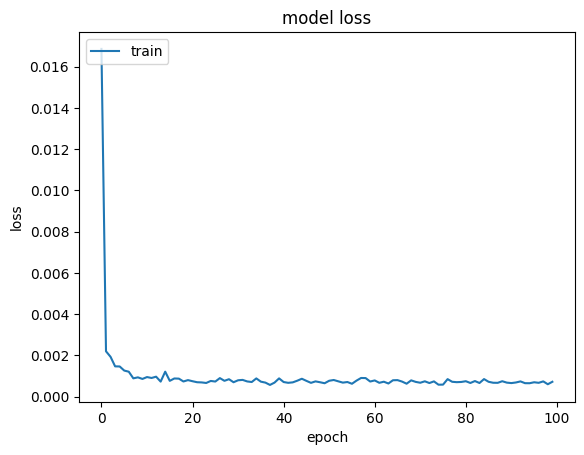

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
capital = 10000


In [25]:
# Tahminleri yap
predictions = model.predict(test_data[:-1].reshape(-1, 1, 1))
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Tahminleri bir DataFrame'e aktar
predictions = pd.DataFrame(predictions, index=data.tail(len(test_data)-1).index, columns=['Predicted'])

# Alım satım sinyallerini belirle
predictions['Signal'] = np.where(predictions['Predicted'] > predictions['Predicted'].shift(), 'SAT', 'AL')

# Alım satım kararlarını hesapla
stock_data = data.tail(len(test_data))
actions = pd.DataFrame(index=stock_data.index, columns=['Signal', 'Price'])
actions['Signal'] = predictions['Signal']
actions['Price'] = stock_data['Close']




# Hesaplamaları yap
for i in range(1, len(actions)):
    # Fiyatların sonraki 5 gününe ilişkin tahminleri kontrol et
    if not pd.isnull(actions.iloc[i]['Signal']):
        # Sinyal varsa, karar alın
        if actions.iloc[i]['Signal'] == 'AL':
            # Alım işlemi yap
            actions.iloc[i]['Price'] *= 1.0025
            capital -= actions.iloc[i]['Price']
        else:
            # Satım işlemi yap
            actions.iloc[i]['Price'] *= 0.9975
            capital += actions.iloc[i]['Price']
    else:
        # Sinyal yoksa, mevcut pozisyonları kontrol et
        if not pd.isnull(actions.iloc[i-1]['Signal']):
            if actions.iloc[i-1]['Signal'] == 'AL':
                # Uzun pozisyonda kal
                actions.iloc[i]['Price'] = actions.iloc[i-1]['Price']
            else:
                # Kısa pozisyonda kal
                actions.iloc[i]['Price'] = actions.iloc[i-1]['Price']



11/11 [==============================] - 1s 4ms/step


<ipython-input-25-e999f33c6f8a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions.iloc[i]['Price'] *= 1.0025
<ipython-input-25-e999f33c6f8a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions.iloc[i]['Price'] *= 0.9975


In [26]:
print("İlk sermaye: $%.2f" % 10000.0)
print("Son sermaye: $%.2f" % capital)
print("Kar: $%.2f" % (capital - 10000.0))
print("Kar oranı: %.2f%%" % ((capital / 10000.0 - 1.0) * 100))

İlk sermaye: $10000.00
Son sermaye: $15281.89
Kar: $5281.89
Kar oranı: 52.82%


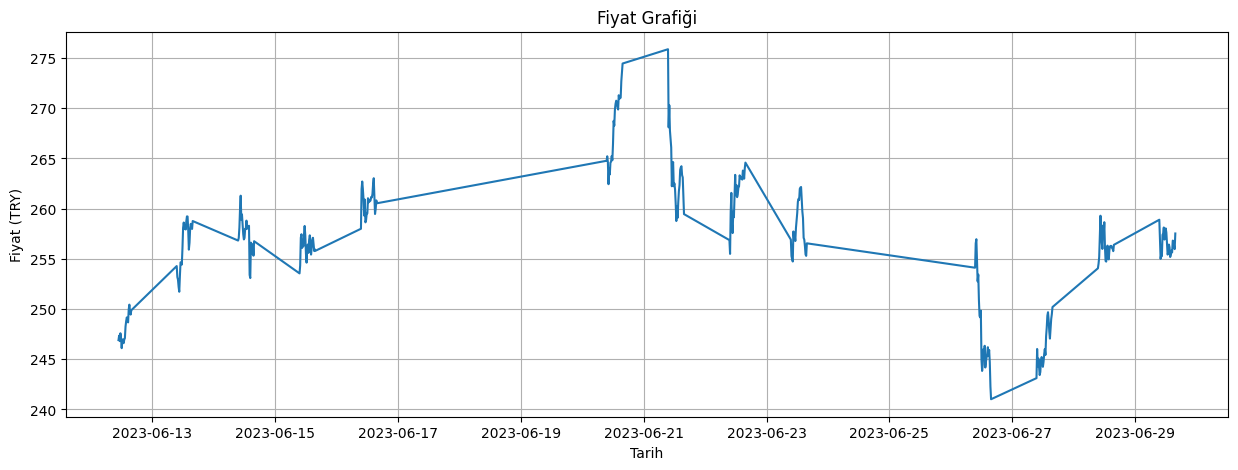

In [27]:
import matplotlib.pyplot as plt

# Fiyat grafiğini oluştur
plt.figure(figsize=(15,5))
plt.plot(actions.index, actions['Price'])
plt.title('Fiyat Grafiği')
plt.xlabel('Tarih')
plt.ylabel('Fiyat (TRY)')
plt.grid()
plt.show()


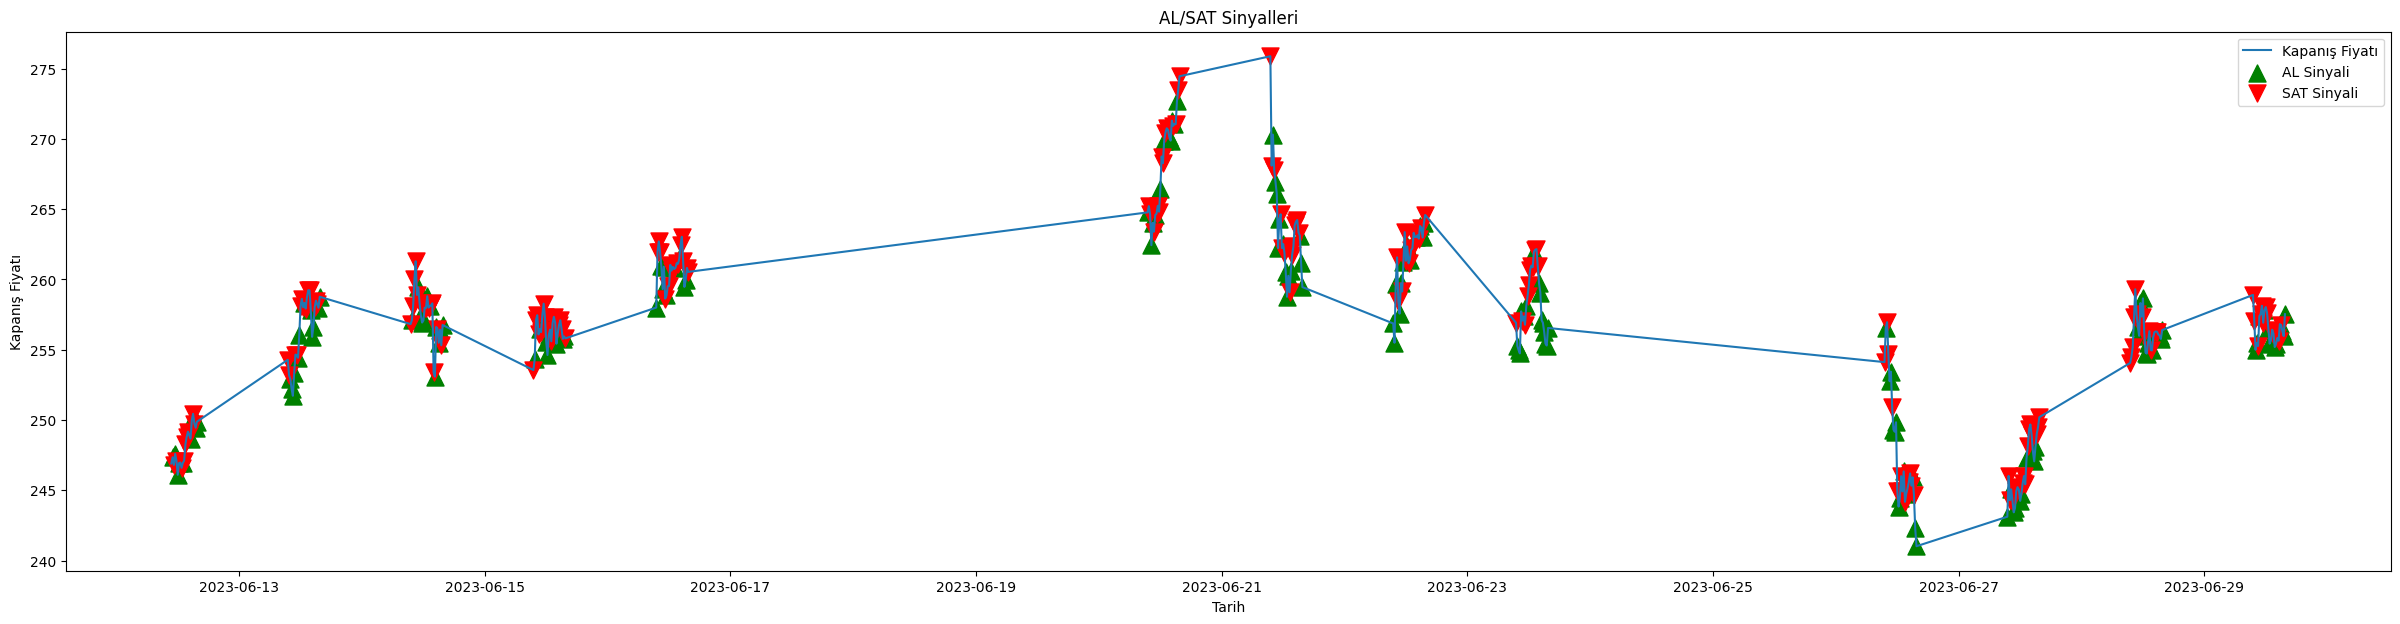

In [28]:
import matplotlib.pyplot as plt

# Fiyat grafiğini çizdir
fig = plt.figure(figsize=(30,7))
plt.plot(stock_data.index, stock_data['Close'])

# Alış ve satış sinyallerini göster
buy_signals = actions[actions['Signal'] == 'AL']
sell_signals = actions[actions['Signal'] == 'SAT']
plt.scatter(buy_signals.index, buy_signals['Price'], color='green', marker='^',s=150)
plt.scatter(sell_signals.index, sell_signals['Price'], color='red', marker='v',s=150)

# Grafik ayarları
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.title('AL/SAT Sinyalleri')
plt.legend(['Kapanış Fiyatı', 'AL Sinyali', 'SAT Sinyali'])
plt.show()


In [29]:
predictions = model.predict(test_data[:-4].reshape(-1, 1, 1))
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

predictions = pd.DataFrame(predictions, index=data.tail(len(test_data)-4).index, columns=['Predicted'])

predictions['Signal'] = np.where(predictions['Predicted'] > predictions['Predicted'].shift(4), 'SAT', 'AL')

predictions['Signal'] = predictions['Signal'].shift(-4)

stock_data = data.tail(len(test_data))
actions = pd.DataFrame(index=stock_data.index, columns=['Signal', 'Price'])
actions['Signal'] = predictions['Signal']
actions['Price'] = stock_data['Close']

capital = 10000.0


11/11 [==============================] - 0s 3ms/step


In [30]:
for i in range(4, len(actions)):
# Sinyalleri kontrol et, 5 günlük periyotlarda karar alın
    if not pd.isnull(actions.iloc[i]['Signal']):
# Sinyal varsa, karar alın
      if actions.iloc[i]['Signal'] == 'AL':
        # Alım işlemi yap
        actions.iloc[i]['Price'] *= 1.0050
        capital -= actions.iloc[i]['Price']
      else:
# Satım işlemi yap
        actions.iloc[i]['Price'] *= 0.9950
        capital += actions.iloc[i]['Price']
    else:
# Sinyal yoksa, mevcut pozisyonları kontrol et
        if not pd.isnull(actions.iloc[i-1]['Signal']):
          if actions.iloc[i-1]['Signal'] == 'AL':
            # Uzun pozisyonda kal
            actions.iloc[i]['Price'] = actions.iloc[i-1]['Price']
          else:
            # Kısa pozisyonda kal
            actions.iloc[i]['Price'] = actions.iloc[i-1]['Price']

<ipython-input-30-aa3516616387>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions.iloc[i]['Price'] *= 0.9950
<ipython-input-30-aa3516616387>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions.iloc[i]['Price'] *= 1.0050
<ipython-input-30-aa3516616387>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions.iloc[i]['Price'] = actions.iloc[i-1]['Price']


In [31]:
print("İlk sermaye: $%.2f" % 10000.0)
print("Son sermaye: $%.2f" % capital)
print("Kar: $%.2f" % (capital - 10000.0))
print("Kar oranı: %.2f%%" % ((capital / 10000.0 - 1.0) * 100))

İlk sermaye: $10000.00
Son sermaye: $23443.69
Kar: $13443.69
Kar oranı: 134.44%


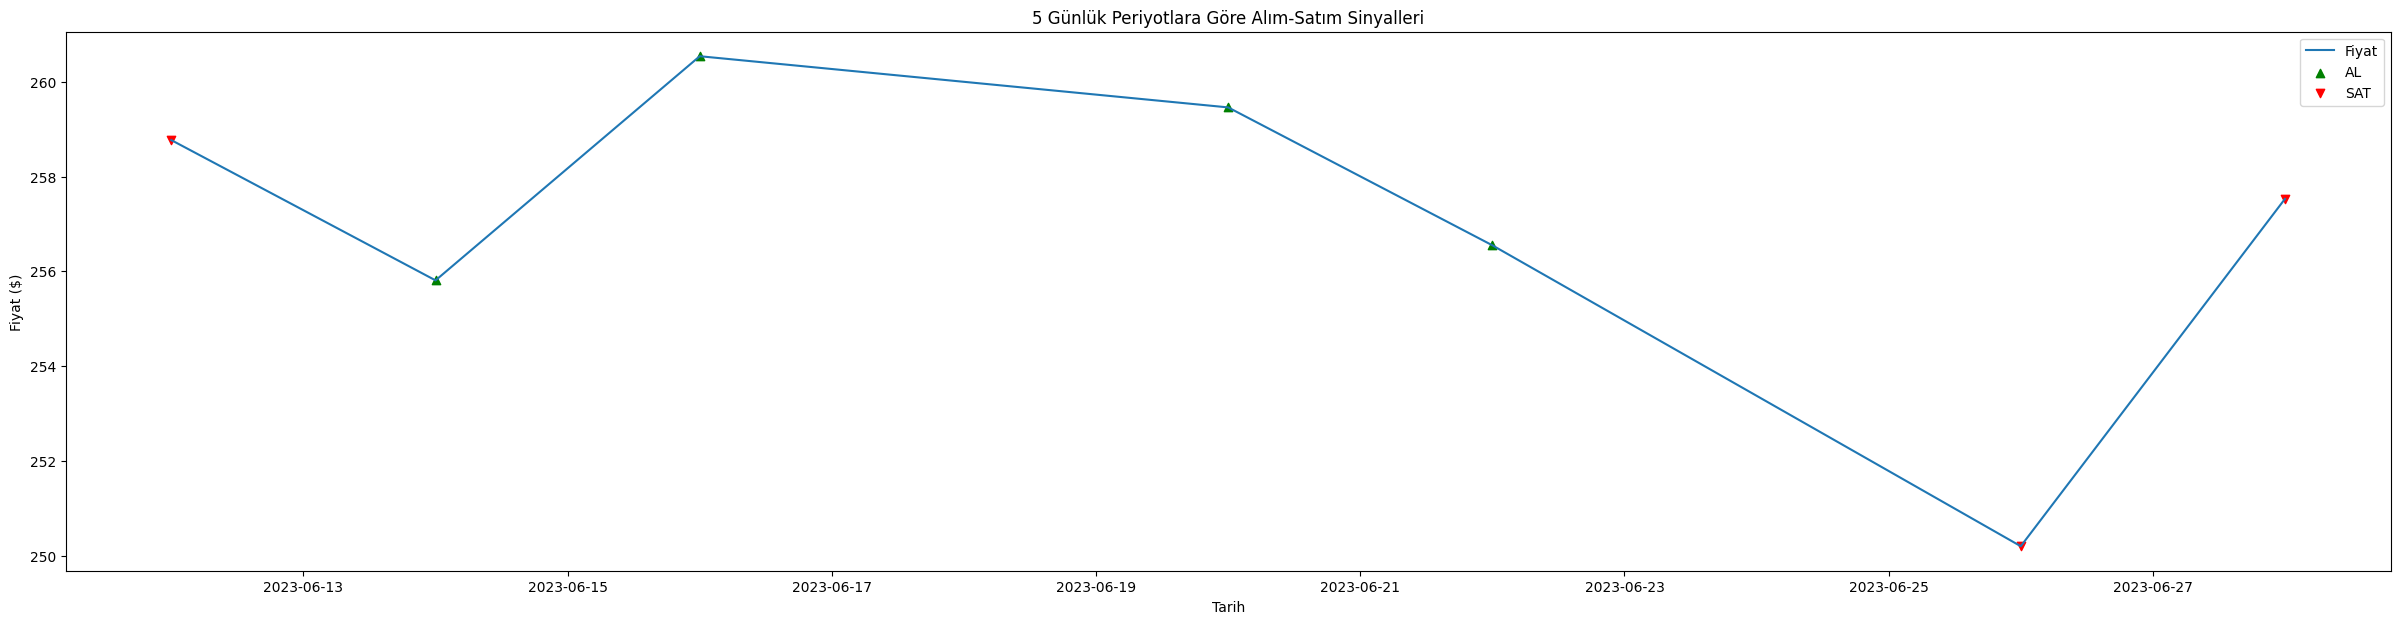

In [32]:
import matplotlib.pyplot as plt

# Sinyalleri ve fiyatları içeren bir DataFrame oluştur
signals_df = pd.concat([actions['Signal'], actions['Price']], axis=1)

# 5 günlük periyotlara göre örneklemle ve sinyalleri getir
resampled_signals = signals_df.resample('2D').last().dropna()

# Grafik oluştur
fig, ax = plt.subplots(figsize=(30,7))

# Fiyatları çizdir
ax.plot(resampled_signals.index, resampled_signals['Price'], label='Fiyat')

# Alım satım sinyallerini çizdir
ax.scatter(resampled_signals[resampled_signals['Signal'] == 'AL'].index,
           resampled_signals[resampled_signals['Signal'] == 'AL']['Price'],
           marker='^', color='green', label='AL')

ax.scatter(resampled_signals[resampled_signals['Signal'] == 'SAT'].index,
           resampled_signals[resampled_signals['Signal'] == 'SAT']['Price'],
           marker='v', color='red', label='SAT')

# Eksenleri ve başlıkları ayarla
ax.set_xlabel('Tarih')
ax.set_ylabel('Fiyat ($)')
ax.set_title('5 Günlük Periyotlara Göre Alım-Satım Sinyalleri')
ax.legend()

# Grafiği göster
plt.show()


In [33]:
for i in range(4, len(actions)):
# Sinyalleri kontrol et, 5 günlük periyotlarda karar alın
    if not pd.isnull(actions.iloc[i]['Signal']):
# Sinyal varsa, karar alın
      if actions.iloc[i]['Signal'] == 'AL':
        # Alım işlemi yap
        actions.iloc[i]['Price'] *= 1.0050
        capital -= actions.iloc[i]['Price']
      else:
# Satım işlemi yap
        actions.iloc[i]['Price'] *= 0.9950
        capital += actions.iloc[i]['Price']
    else:
# Sinyal yoksa, mevcut pozisyonları kontrol et
        if not pd.isnull(actions.iloc[i-1]['Signal']):
          if actions.iloc[i-1]['Signal'] == 'AL':
            # Uzun pozisyonda kal
            actions.iloc[i]['Price'] = actions.iloc[i-1]['Price']
          else:
            # Kısa pozisyonda kal
            actions.iloc[i]['Price'] = actions.iloc[i-1]['Price']

<ipython-input-33-aa3516616387>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions.iloc[i]['Price'] *= 0.9950
<ipython-input-33-aa3516616387>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions.iloc[i]['Price'] *= 1.0050
<ipython-input-33-aa3516616387>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions.iloc[i]['Price'] = actions.iloc[i-1]['Price']


In [34]:
print("İlk sermaye: $%.2f" % 10000.0)
print("Son sermaye: $%.2f" % capital)
print("Kar: $%.2f" % (capital - 10000.0))
print("Kar oranı: %.2f%%" % ((capital / 10000.0 - 1.0) * 100))

İlk sermaye: $10000.00
Son sermaye: $36887.38
Kar: $26887.38
Kar oranı: 268.87%
